# Advanced ML

## Gamma Poisson Conjugate

Reference: https://juanitorduz.github.io/intro_pymc3/

In [3]:
import numpy as np
import scipy.stats as ss
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

### Poisson Distribution

Consider n samples of Y∼Poiss(λ). Recall that the Poisson distribution is given by:

$$\displaystyle{
f(y_i|\lambda)=\frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
}$$

where λ>0. It is easy to verify that the expected value and variance are E(Y)=λ and Var(Y)=λ respectively. Parallel to the formal discussion, we are going to implement a numerical simulation:

In [4]:
# We set a seed so that the results are reproducible.
np.random.seed(5)

# number of samples.
n = 100

# true parameter.
lam_true = 2

# sample array.
y = np.random.poisson(lam=lam_true, size=n)

y

array([2, 4, 1, 0, 2, 2, 2, 2, 1, 1, 3, 2, 0, 1, 3, 3, 4, 2, 0, 0, 3, 6,
       1, 2, 1, 2, 5, 2, 3, 0, 1, 3, 1, 4, 1, 2, 4, 0, 6, 4, 1, 2, 2, 0,
       1, 2, 4, 4, 1, 3, 0, 3, 3, 2, 4, 2, 2, 1, 1, 2, 5, 2, 3, 0, 1, 1,
       1, 3, 4, 1, 3, 4, 2, 1, 2, 4, 2, 2, 1, 0, 2, 2, 3, 0, 3, 3, 4, 2,
       2, 1, 2, 1, 3, 0, 1, 0, 3, 3, 1, 2])

In [5]:
# mean of the sample.
y.mean()

2.06

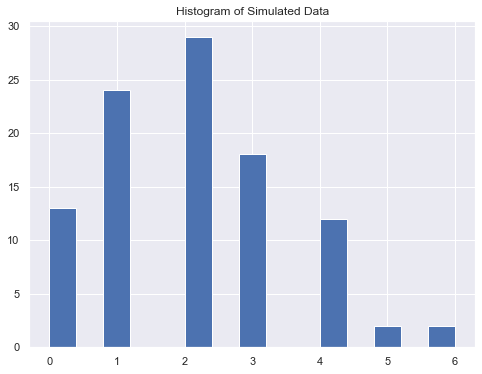

In [6]:
# Histogram of the sample.
plt.figure(figsize=(8, 6))
plt.hist(y, bins=15)
plt.title('Histogram of Simulated Data');

### Prior:  Gamma Distribution

Let us consider a gamma prior distribution for the parameter λ∼Γ(a,b). Recall that the density function for the gamma distribution is

$$\begin{equation}
f(\lambda)=\frac{b^a}{\Gamma(a)}\lambda^{a-1} e^{-b\lambda}
\end{equation}$$

where a>0 is the shape parameter and b>0 is the rate parameter. One verifies that

$$\text{E}(\lambda)=\frac{a}{b}
\quad
\text{and}
\quad
\text{Var}(\lambda)=\frac{a}{b^2}$$

Let us plot a gamma distribution for parameters a=3.5 and b=2.

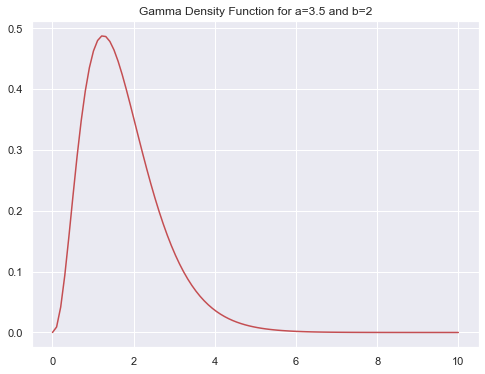

In [7]:
# Parameters of the prior gamma distribution.
a = 3.5 # shape
b = 2 # rate = 1/scale

x = np.linspace(start=0, stop=10, num=100)

plt.figure(figsize=(8, 6))
plt.plot(x, ss.gamma.pdf(x,a=a,scale=1/b), 'r-')
plt.title('Gamma Density Function for a={} and b={}'.format(a,b))

# Define the prior distribution.
prior = lambda x: ss.gamma.pdf(x, a=a, scale=1/b)

### Likelihood

As the observations are independent the likelihood function is

$$\begin{align}
f(y|\lambda)=&\prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
=\frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^{n}y_i!}
\end{align}$$

In [8]:
# Define the likelihood function.
def likelihood(lam,y):
    
    factorials = np.apply_along_axis(
        lambda x: sp.gamma(x+1),
        axis=0,
        arr=y
    )
    
    numerator = np.exp(-lam*y.size)*(lam**y.sum())
    
    denominator = np.multiply.reduce(factorials)
    
    return numerator/denominator  

### Posterior distribution for λ up to a constant

As we are just interested in the structure of the posterior distribution, up to a constant, we see:

$$\begin{align}
f(\lambda|y)\propto & \text{likelihood} \times \text{prior}\\
\propto & \quad f(y|\lambda)f(\lambda)\\
\propto & \quad e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i} \lambda^{a-1} e^{-b\lambda}\\
\propto & \quad \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}\\
\end{align}$$

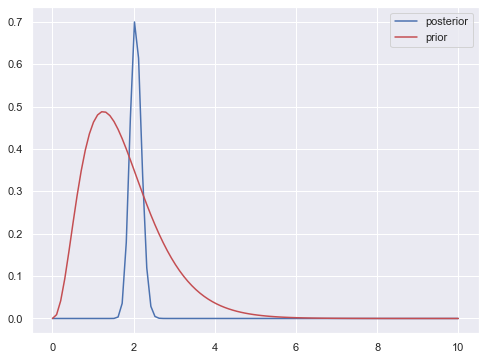

In [9]:
# Define the posterior distribution.
# (up to a constant)
def posterior_up_to_constant(lam,y):
    return likelihood(lam,y)*prior(lam)

# Plot of the prior and (scaled) posterior distribution
# for the parameter lambda.
#
# We multiply the posterior distrubution function
# by the amplitude factor 2.5e74 to make it comparable
# with the prior gamma distribution.

plt.figure(figsize=(8, 6))
plt.plot(x, 2.0e74*posterior_up_to_constant(x,y), label='posterior')
plt.plot(x, ss.gamma.pdf(x,a=a,scale=1/b), 'r-', label='prior')
plt.legend();

### True posterior distribution for λ

Since $f(\lambda|y) \propto\: \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}$, the posterior distribution is again a Gamma

$$\begin{align}
f(\lambda|y) = \Gamma\left(\sum_{i=1}^n y_i+a, n+b\right)
\end{align}$$


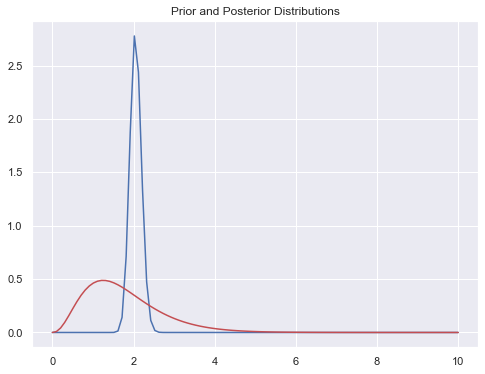

In [10]:
def posterior(lam,y):
    
    shape = a + y.sum()
    rate = b + y.size
    
    return ss.gamma.pdf(lam, shape, scale=1/rate)

plt.figure(figsize=(8, 6))
plt.plot(x, posterior(x,y))
plt.plot(x, ss.gamma.pdf(x,a=a,scale=1/b), 'r-')
plt.title('Prior and Posterior Distributions');

We indeed see how the posterior distribution is concentrated around the true parameter λ=2

Note that the posterior mean is 

$$\begin{align}
\frac{\sum_{i=1}^n y_i+a}{n+b} = \frac{b}{n+b}\frac{a}{b}+\frac{n}{n+b}\frac{\sum_{i=1}^n y_i}{n}
\end{align}$$

That is, it is a weighted average of the prior mean a/b and the sample average $\bar{y}$ As n increases,

$$\begin{align}
\lim_{n\rightarrow +\infty}\frac{b}{n+b}\frac{a}{b}+\frac{n}{n+b}\frac{\sum_{i=1}^n y_i}{n} = \bar{y}.
\end{align}$$

In [11]:
# Posterior gamma parameters.
shape = a + y.sum()
rate = b + y.size

# Posterior mean.
shape/rate

2.053921568627451

### Markov Chain Monte Carlo (MCMC)

In the last example the posterior distribution was easy to identify. However, in paractice this is not usually the case and therefore, via Bayes Theorem, we would only know the posterior distribution up to a constant. This motivates the idea of using Monte Carlo simulation methods.

In [12]:
import pymc3 as pm

model = pm.Model()

with model:
    
    # Define the prior of the parameter lambda.
    lam = pm.Gamma('lambda', alpha=a, beta=b)
    
    # Define the likelihood function.
    y_obs = pm.Poisson('y_obs', mu=lam, observed=y)
    
    # Consider 2000 draws and 3 chains.
    trace = pm.sample(draws=2000, chains=3)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\apps\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [lambda]
Sampling 3 chains, 0 divergences: 100%|█████████████████████████████████████████| 7500/7500 [01:32<00:00, 80.88draws/s]


If we do a trace plot we can see two results:

- We see the simulated posterior distribution for 3 independent Markov Chains (so that, when combined, avoid the dependence on the initial point). The 3 different chains correspond to the color blue, green and orange.

- The sample value of lambda for each iteration.


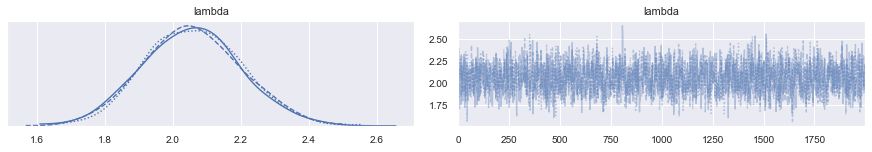

In [13]:
pm.traceplot(trace);

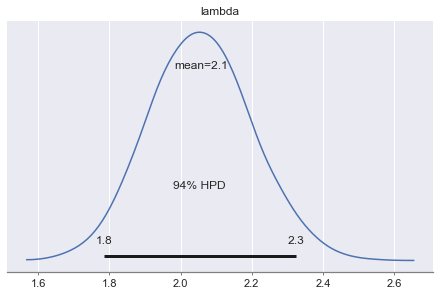

In [14]:
pm.plot_posterior(trace);